In [7]:
!apt-get update
!apt-get install -y libsndfile1


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.8 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://cli.github.com/packages stable/main amd64 Packages [356 B]
Get:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,608 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [70.9 kB]
Get:1

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf


import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
# Paths for data.
Ravdess = "/content/drive/MyDrive/DATASETS/Ravdess/"
Crema = "/content/drive/MyDrive/DATASETS/CREMA-D/AudioWAV/"
Tess = "//content/drive/MyDrive/DATASETS/TESS/"


In [9]:
import os
import pandas as pd

ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    actor_path = os.path.join(Ravdess, dir)

    # process only directories (Actor_01, Actor_02, ...)
    if not os.path.isdir(actor_path):
        continue

    for file in os.listdir(actor_path):

        # process only wav files
        if not file.endswith(".wav"):
            continue

        parts = file.split('.')[0].split('-')

        # valid RAVDESS files must have at least 3 parts
        if len(parts) < 3:
            continue

        emotion = int(parts[2])

        file_emotion.append(emotion)
        file_path.append(os.path.join(actor_path, file))

# create dataframe
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# map emotion labels
Ravdess_df['Emotions'] = Ravdess_df['Emotions'].replace({
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
})

Ravdess_df.head()


Emotions                                               Path
0  neutral  /content/drive/MyDrive/DATASETS/Ravdess/Actor_...
1  neutral  /content/drive/MyDrive/DATASETS/Ravdess/Actor_...
2  neutral  /content/drive/MyDrive/DATASETS/Ravdess/Actor_...
3     calm  /content/drive/MyDrive/DATASETS/Ravdess/Actor_...
4  neutral  /content/drive/MyDrive/DATASETS/Ravdess/Actor_...

In [10]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0    angry  /content/drive/MyDrive/DATASETS/CREMA-D/AudioW...
1  disgust  /content/drive/MyDrive/DATASETS/CREMA-D/AudioW...
2    happy  /content/drive/MyDrive/DATASETS/CREMA-D/AudioW...
3     fear  /content/drive/MyDrive/DATASETS/CREMA-D/AudioW...
4    angry  /content/drive/MyDrive/DATASETS/CREMA-D/AudioW...

In [11]:
import os
import pandas as pd

tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    dir_path = os.path.join(Tess, dir)

    # process only directories
    if not os.path.isdir(dir_path):
        continue

    for file in os.listdir(dir_path):

        # process only wav files
        if not file.endswith(".wav"):
            continue

        parts = file.split('.')[0].split('_')

        # ensure filename has enough parts
        if len(parts) < 3:
            continue

        emotion = parts[2]

        if emotion == 'ps':
            emotion = 'surprise'

        file_emotion.append(emotion)
        file_path.append(os.path.join(dir_path, file))

# create dataframe
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

Tess_df = pd.concat([emotion_df, path_df], axis=1)

Tess_df.head()


Empty DataFrame
Columns: [Emotions, Path]
Index: []

In [13]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  neutral  /content/drive/MyDrive/DATASETS/Ravdess/Actor_...
1  neutral  /content/drive/MyDrive/DATASETS/Ravdess/Actor_...
2  neutral  /content/drive/MyDrive/DATASETS/Ravdess/Actor_...
3     calm  /content/drive/MyDrive/DATASETS/Ravdess/Actor_...
4  neutral  /content/drive/MyDrive/DATASETS/Ravdess/Actor_...

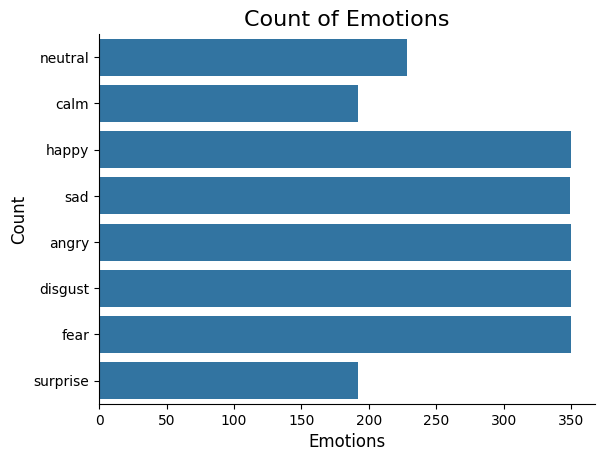

In [14]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [15]:
def create_waveshow(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveshow for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

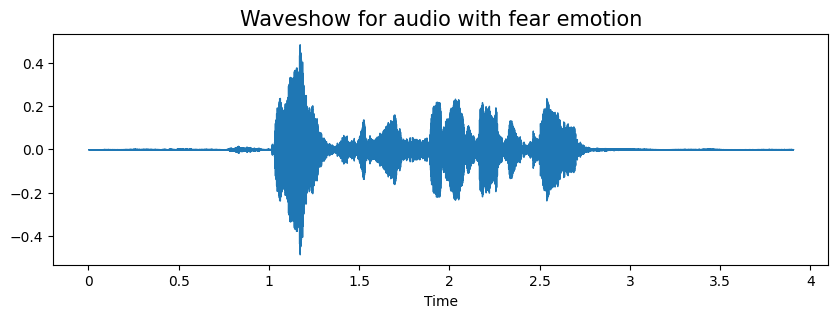

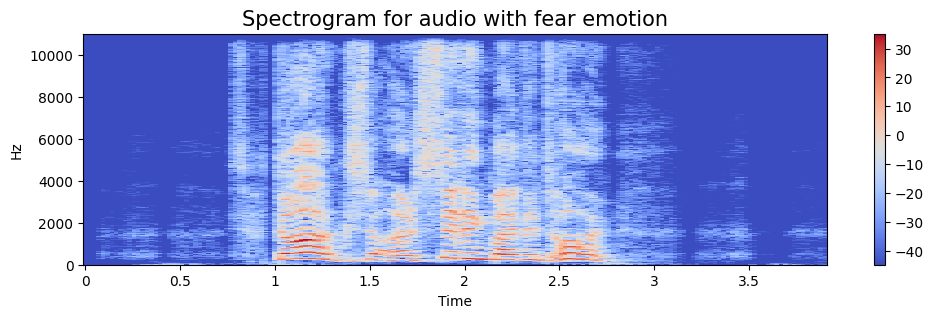

In [16]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveshow(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

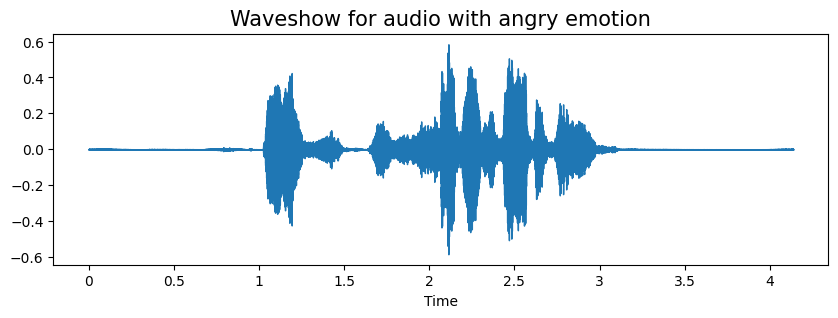

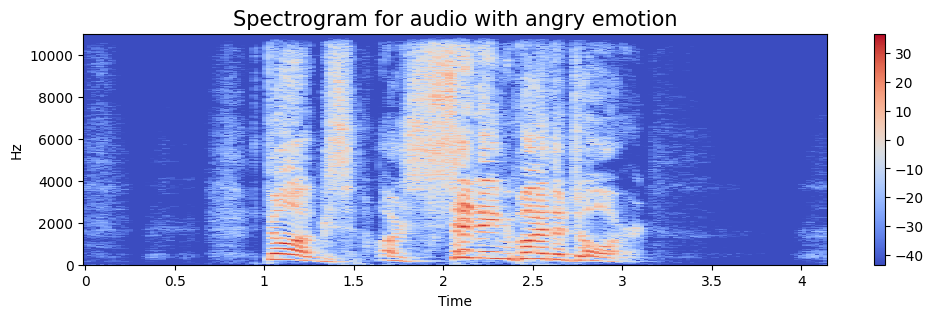

In [17]:

emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveshow(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

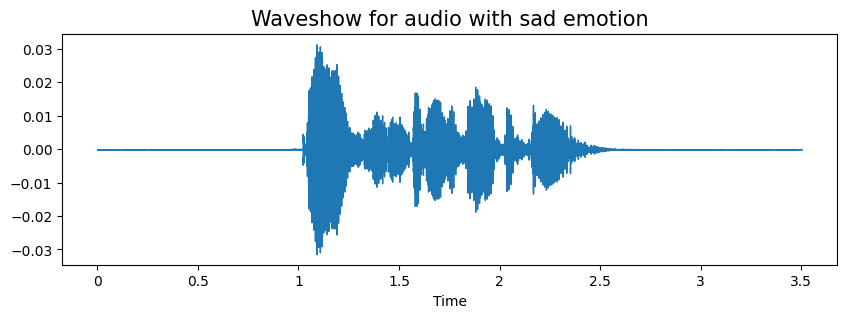

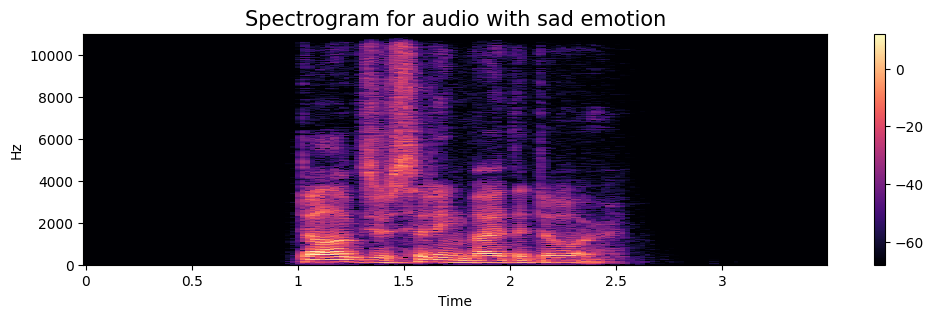

In [18]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveshow(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

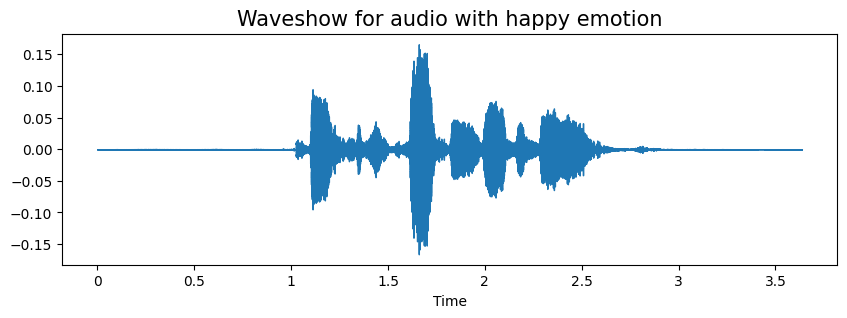

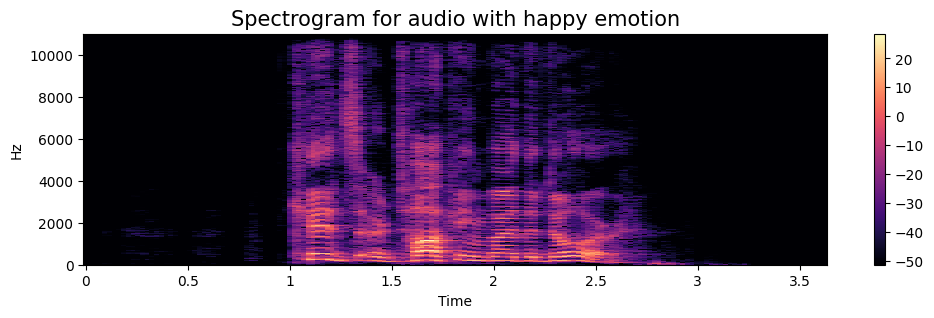

In [19]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveshow(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [20]:
#  Data Augmentation



def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(
        y=data,
        sr=sampling_rate,
        n_steps=pitch_factor
    )


# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

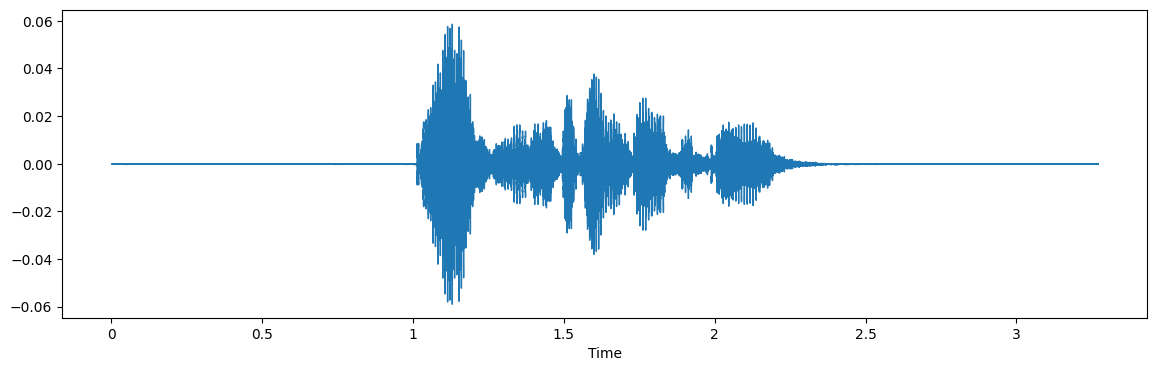

In [21]:
#Simple Audio

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

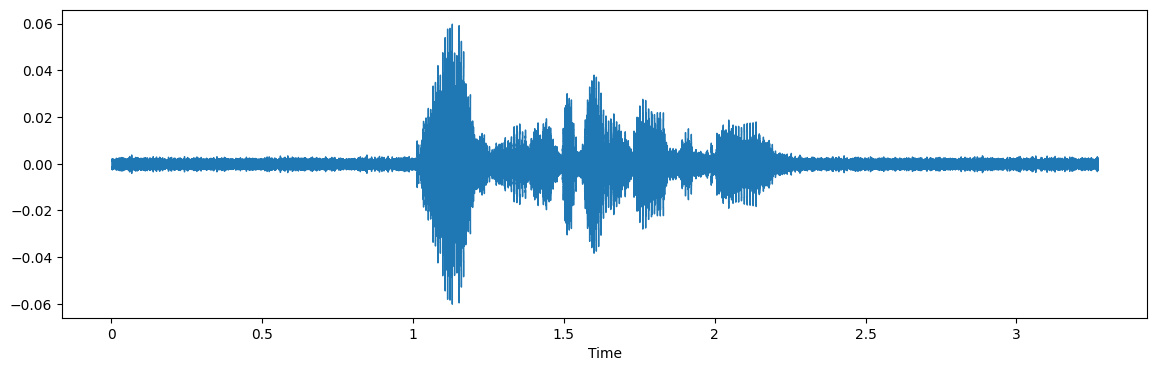

In [22]:
#Noise Injection

x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

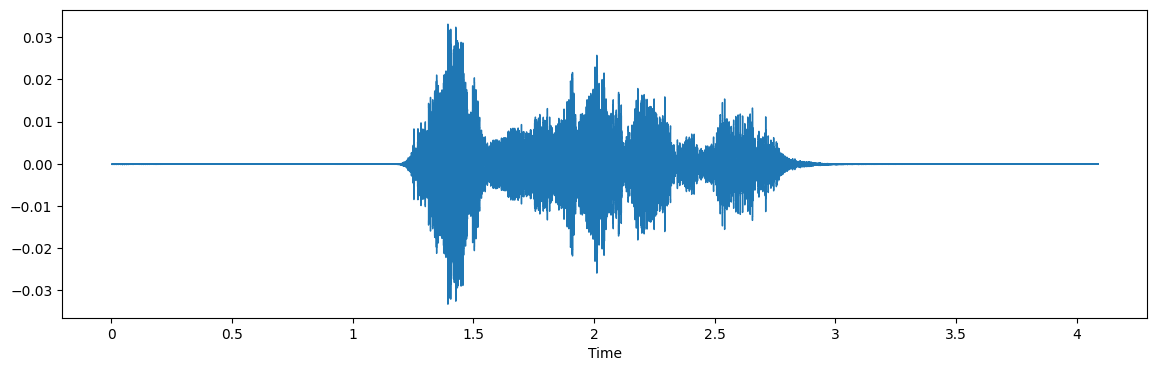

In [23]:
# Stretching

x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

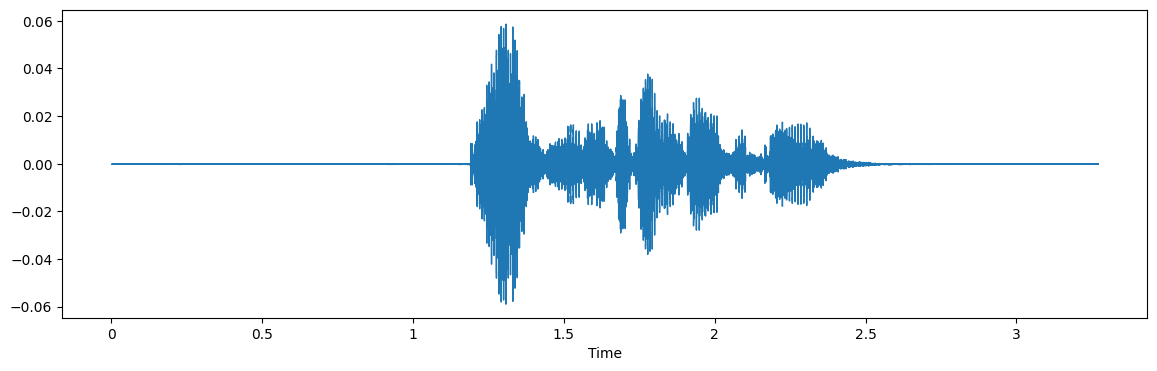

In [24]:
#Shifting

x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

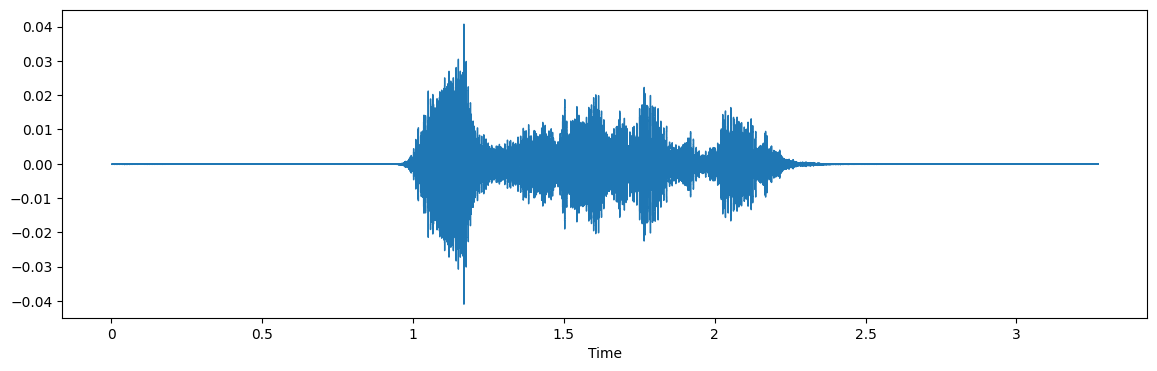

In [25]:
# Pitch

x = pitch(data, sample_rate)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(x, sr=sample_rate)
plt.show()
Audio(x, rate=sample_rate)

In [26]:
# Feature Extraction

"""features:

1. Zero Crossing Rate
2. Chroma_stft
3. MFCC
4. RMS(root mean square) value
5. MelSpectogram to train our model."""


'features:\n\n1. Zero Crossing Rate\n2. Chroma_stft\n3. MFCC\n4. RMS(root mean square) value\n5. MelSpectogram to train our model.'

In [27]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [28]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [29]:
len(X), len(Y), data_path.Path.shape

(7083, 7083, (2361,))

In [30]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.321275  0.729664  0.750033  0.730624  0.735275  0.713529  0.660531   
1  0.332303  0.828068  0.827458  0.812848  0.826146  0.797236  0.690440   
2  0.188213  0.622087  0.699122  0.753255  0.721182  0.701758  0.682380   
3  0.337678  0.715208  0.759374  0.755704  0.757634  0.743580  0.651788   
4  0.341684  0.809172  0.843018  0.831527  0.852369  0.826130  0.710904   

          7         8         9  ...           153           154  \
0  0.684966  0.733049  0.753972  ...  4.310902e-06  3.291511e-06   
1  0.695622  0.743849  0.770893  ...  9.742002e-05  9.856322e-05   
2  0.662864  0.686524  0.734023  ...  8.576954e-07  9.576502e-07   
3  0.629598  0.679255  0.737464  ...  1.279415e-05  1.287855e-05   
4  0.653622  0.715646  0.759542  ...  2.783429e-04  2.610114e-04   

            155           156           157           158       159       160  \
0  2.148075e-06  2.279739e-06  5.116492e-06  8.190280e-06  0.000007  0.000005   
1  9.999448e-05  9.928783e-05  9.691104e-05  1.037429e-04  0.000099  0.000094   
2  7.733658e-07  5.233111e-07  3.593635e-07  9.267901e-07  0.000002  0.000001   
3  1.521516e-05  1.980499e-05  2.768533e-05  4.845906e-05  0.000032  0.000018   
4  2.721126e-04  2.972484e-04  2.823591e-04  3.032276e-04  0.000286  0.000281   

            161   labels  
0  4.245835e-07  neutral  
1  9.398773e-05  neutral  
2  7.753689e-08  neutral  
3  1.461863e-06  neutral  
4  2.488077e-04  neutral  

[5 rows x 163 columns]

In [31]:
# Data Preparation

X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [32]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [33]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5312, 162), (5312, 8), (1771, 162), (1771, 8))

In [34]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5312, 162), (5312, 8), (1771, 162), (1771, 8))

In [35]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5312, 162, 1), (5312, 8), (1771, 162, 1), (1771, 8))

In [36]:
# Modelling

In [37]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 81, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,288 (2.13 MB)

 Trainable params: 557,288 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 492ms/step - accuracy: 0.1940 - loss: 2.0067 - val_accuracy: 0.2428 - val_loss: 1.8704 - learning_rate: 0.0010
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 38s 459ms/step - accuracy: 0.2308 - loss: 1.8914 - val_accuracy: 0.2874 - val_loss: 1.7894 - learning_rate: 0.0010
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 42s 477ms/step - accuracy: 0.2414 - loss: 1.8568 - val_accuracy: 0.3072 - val_loss: 1.7526 - learning_rate: 0.0010
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 40s 478ms/step - accuracy: 0.2845 - loss: 1.7925 - val_accuracy: 0.3219 - val_loss: 1.7102 - learning_rate: 0.0010
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 38s 459ms/step - accuracy: 0.2926 - loss: 1.7481 - val_accuracy: 0.3264 - val_loss: 1.6864 - learning_rate: 0.0010
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 40s 474ms/step - accuracy: 0.3124 - loss: 1.7319 - val_accuracy: 0.3399 - val_loss: 1.6876 - learning_rate: 0.0010
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 40s 478ms/step - accuracy: 0.3339 - loss: 1.

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5617 - loss: 1.4977
Accuracy of our model on test data :  56.747597455978394 %


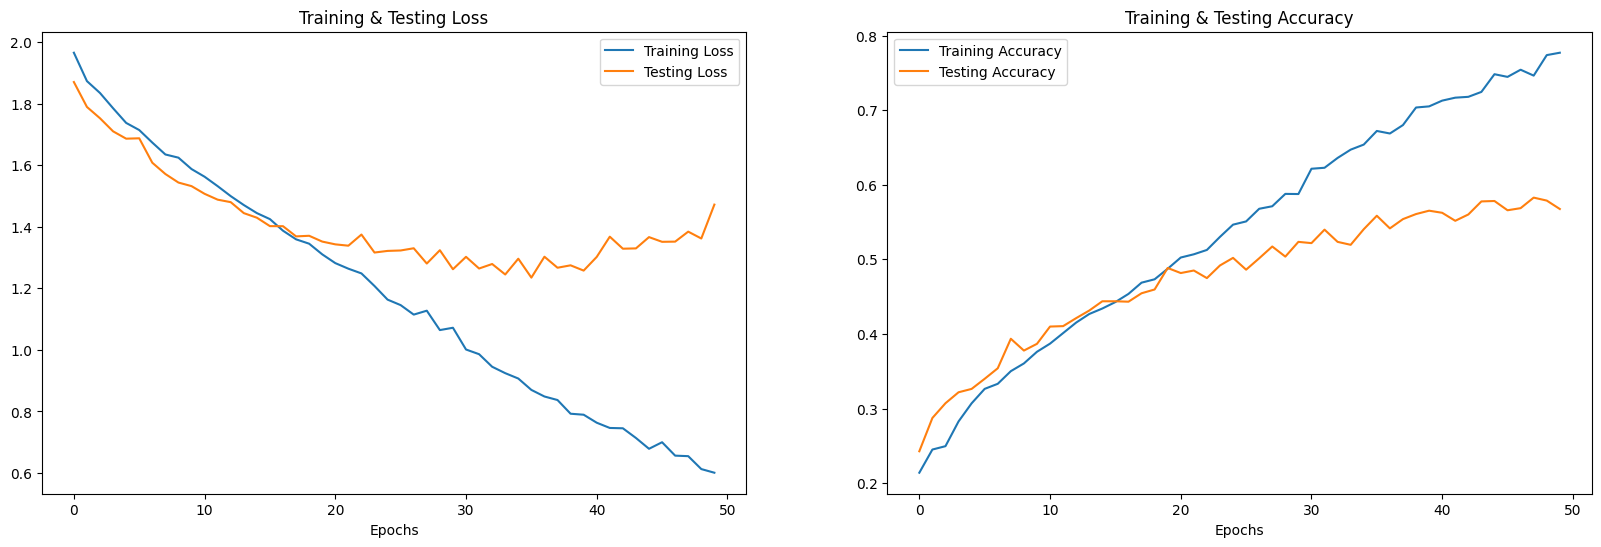

In [39]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [40]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step


In [41]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0            angry         angry
1             fear         angry
2             calm           sad
3            angry         angry
4            happy          fear
5            angry         angry
6              sad       disgust
7            happy         happy
8            angry         angry
9            angry         angry

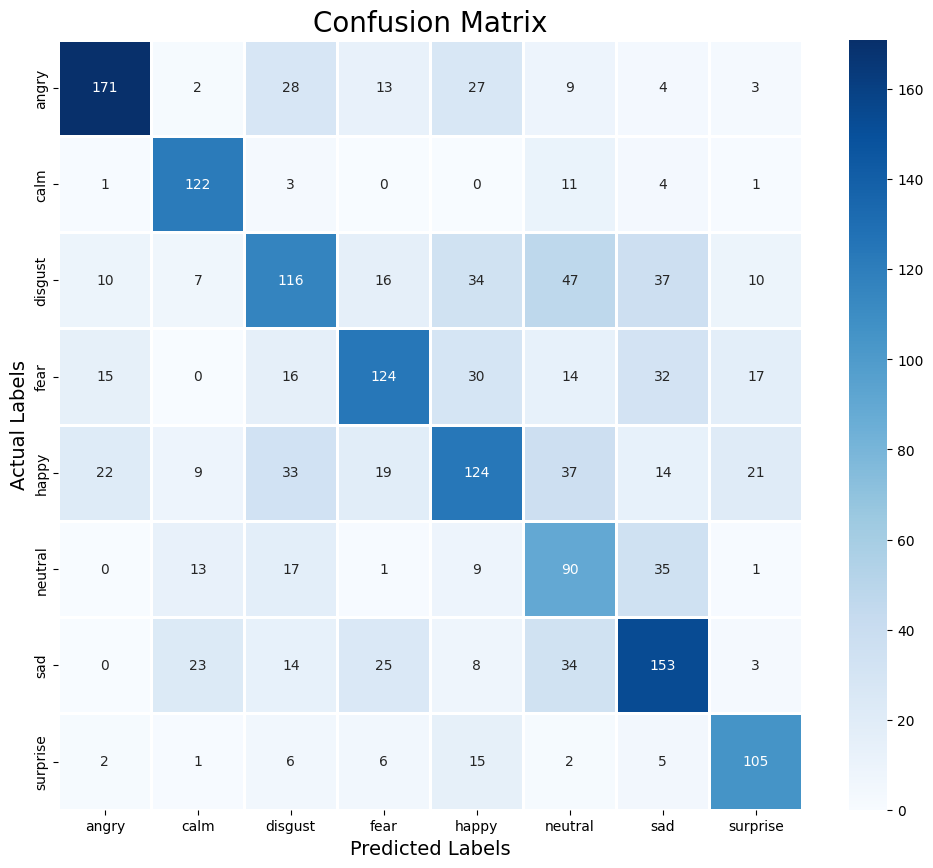

In [42]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.77      0.67      0.72       257
        calm       0.69      0.86      0.76       142
     disgust       0.50      0.42      0.45       277
        fear       0.61      0.50      0.55       248
       happy       0.50      0.44      0.47       279
     neutral       0.37      0.54      0.44       166
         sad       0.54      0.59      0.56       260
    surprise       0.65      0.74      0.69       142

    accuracy                           0.57      1771
   macro avg       0.58      0.59      0.58      1771
weighted avg       0.58      0.57      0.57      1771

